In [1]:
import re
import time
import json
import requests
import datetime
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint
from bs4 import BeautifulSoup

In [18]:
headers = {
'Host' : 'auto.ru',
'User-Agent' : 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:94.0) Gecko/20100101 Firefox/94.0',
'Accept' : 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
'Accept-Language' : 'en-US,en;q=0.5',
'Accept-Encoding' : 'gzip, deflate, br',
'Connection' : 'keep-alive',
'Cookie' : 'autoru_gdpr=1; suid=bc8be712d638a08131a6e9e0d202d740.c5b54afb905b8c06122ab3a791bcd52b; yandexuid=2760879651631376416; my=YysBAgA%3D; counter_ga_all7=2; credit_filter_promo_popup_closed=true; bltsr=1; autoru-visits-count=5; autoru_sid=a%3Ag619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26%7C1637509921806.604800.1BSyVNdQ_Jgiakk7ftwSsg.rxF87OjlP3hNehiaJwY7hz1CT9Y7Izf61mSqV5Ly0C8; autoruuid=g619130a126cnq19ulaaft362m5p2vb2.ce95d73e09b71591f2b431378fbd3c26; crookie=jpj0jVvWTMkqF2bLNEjq1Sm8BK5liRI8I2IDRbmuxJB1Z9qhACbqZpnyGeU1riNvks6acZdg/tULhikIF+VQKxi5Ddo=; deal_million_popup_page_seen=-1; credit_modal_autoshow_closed=true; _yasc=BXlfPgARlvaqwGCFNYlOD81UvI/rudyiPXKWSUFuIbFRxQ==; _csrf_token=cd33b362bade8bf97053fcccb6e8a730d67cea3890bc13dd; from_lifetime=1637870096528; from=direct; safe_deal_promo=0; yuidlt=1; cmtchd=MTYzNzg2MjAxMjI2OQ==; X-Vertis-DC=sas; los=1',
'Upgrade-Insecure-Requests' : '1',
'Sec-Fetch-Dest' : 'document',
'Sec-Fetch-Mode' : 'navigate',
'Sec-Fetch-Site' : 'none',
'Sec-Fetch-User' : '?1'
}
page_suffix = '?page='

In [19]:
perks = ['Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'bodyType', 'brand', 'color', 'complectation_dict', 'description', 'engineDisplacement', 
      'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name', 
      'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id', 'super_gen', 
      'vehicleConfiguration', 'vehicleTransmission', 'vendor', 'car_url']

In [20]:
def get_ad_info(url, headers, characteristics):
    ad_info = dict()   
    r = requests.get(url, headers=headers)
    html = BeautifulSoup(r.content, 'html.parser')
    for li in html.find_all('li', 'CardInfoRow'):
        var1, var2 = tuple(li.children)
        key = var1.string
        value = var2.string
        if key in perks[:7]:
            ad_info[key] = value
    
    try:
        j1 = json.loads(html.script.string)
    except:
        return
    
    try:
        j2 = json.loads(html.find('script', id="initial-state").string)
    except:
        return
        
    for k in set(perks).intersection(set(j1)):
        ad_info[k] = j1[k]

    for l in set(perks).intersection(j1['vehicleEngine']):
        try:
            ad_info[l] = j1['vehicleEngine'][l]
        except:
            pass

    for m in set(perks).intersection(j2['card']['state']):
        try:
            ad_info[m] = j2['card']['state'][m]
        except:
            pass

    try: 
        ad_info['equipment_dict'] = j2['card']['vehicle_info']['equipment'] 
    except: 
        pass
    
    try: 
        ad_info['complectation_dict'] = j2['card']['vehicle_info']['complectation'] 
    except: 
        pass
    
    try: 
        ad_info['model_info'] = j2['card']['vehicle_info']['model_info'] 
    except: 
        pass
    
    try: 
        ad_info['model_name'] = j2['card']['vehicle_info']['model_info']['name'] 
    except: 
        pass
    
    try: 
        ad_info['super_gen'] = j2['card']['vehicle_info']['super_gen'] 
    except: 
        pass
    
    try: 
        ad_info['vendor'] = j2['card']['vehicle_info']['vendor'] 
    except: 
        pass
    
    try: 
        ad_info['sell_id'] = j2['card']['saleId'] 
    except: 
        pass
    

    try: 
        ad_info['price'] = j1['offers']['price'] 
    except: 
        pass
    
    try: 
        ad_info['priceCurrency'] = j1['offers']['priceCurrency'] 
    except: 
        pass
    
    try: 
        ad_info['car_url'] = j1['offers']['url'] 
    except: 
        pass
    

    ad_info['parsing_unixtime'] = time.time()

    return ad_info

In [ ]:
time_start = datetime.datetime.now()
makes = ['', 'renault', 'toyota', 'mercedes', 'audi', 'hyundai', 'ford']
makes = ['vaz', 'chevrolet', 'mitsubishi', 'volkswagen']
for make in makes:
    df = pd.DataFrame(columns=perks)
    print(f'{make=}')
    url = 'https://auto.ru/cars/' + make + '/all/'
    rng = range(1, 100)
    for page_num in rng:
        if page_num <=1:
            page_url = url
        else:
            page_url = url + page_suffix + str(page_num)
        res = requests.get(page_url, headers=headers)
        code = BeautifulSoup(res.content, 'html.parser')
        ad_links = code.find_all("a", class_="ListingItemTitle__link")
        for l in ad_links:
            link = l['href']
            print(f'{page_num = }  __  {link = }')
            car_info = get_ad_info(link, headers, perks)
            if car_info is None:
                pass
            else:
                df = df.append(car_info, ignore_index=True,)
            time.sleep(0.5)
    time_passed = datetime.datetime.now() - time_start
    print(f'{time_passed=}')
    df.to_csv('project6' + make + '.csv')

# Работа с данными

In [533]:
df = pd.read_csv('project6.csv')
df = df.append(pd.read_csv('project6audi.csv'))
df = df.append(pd.read_csv('project6_ford_1.csv'))
df = df.append(pd.read_csv('project6_ford_3.csv'))
df = df.append(pd.read_csv('project6_ford_4.csv'))
df = df.append(pd.read_csv('project6hyundai.csv'))
df = df.append(pd.read_csv('project6mercedes.csv'))
df = df.append(pd.read_csv('project6renault.csv'))
df = df.append(pd.read_csv('project6toyota.csv'))
df = df.append(pd.read_csv('project6vaz.csv'))
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28673 entries, 0 to 28672
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 28673 non-null  int64  
 1   Unnamed: 0            28673 non-null  int64  
 2   Владельцы             21776 non-null  object 
 3   Владение              3273 non-null   object 
 4   ПТС                   21776 non-null  object 
 5   Привод                21776 non-null  object 
 6   Руль                  21776 non-null  object 
 7   Состояние             21776 non-null  object 
 8   Таможня               21776 non-null  object 
 9   bodyType              28673 non-null  object 
 10  brand                 28673 non-null  object 
 11  color                 28673 non-null  object 
 12  complectation_dict    28670 non-null  object 
 13  description           28673 non-null  object 
 14  engineDisplacement    28673 non-null  object 
 15  enginePower        

In [535]:
df.columns

Index(['index', 'Unnamed: 0', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'bodyType', 'brand', 'color',
       'complectation_dict', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_info', 'model_name', 'name', 'numberOfDoors',
       'parsing_unixtime', 'priceCurrency', 'productionDate', 'sell_id',
       'super_gen', 'vehicleConfiguration', 'vehicleTransmission', 'vendor',
       'car_url', 'price'],
      dtype='object')

In [536]:
df.sample(10)

,index,Unnamed: 0,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,bodyType,...,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,car_url,price
16499,2539,2539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,седан,...,1.638061e+09,RUB,2021,1105464218-5e8110f2,"{'id': '22491729', 'name': 'VII (W223)', 'ru_n...",SEDAN AUTOMATIC 2.9,автоматическая,EUROPEAN,https://auto.ru/cars/new/group/mercedes/s_klas...,14287800.0
22779,1450,1450,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,седан,...,1.638053e+09,RUB,2016,1103568431-de231371,"{'id': '20229979', 'name': 'VII (XV50) Рестайл...",SEDAN AUTOMATIC 2.5,автоматическая,JAPANESE,https://auto.ru/cars/used/sale/toyota/camry/11...,1698000.0
1965,1965,1965,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,1.637267e+09,RUB,2015,1106006312-8a5cdde4,"{'id': '20213302', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS VARIATOR 1.6,вариатор,JAPANESE,https://auto.ru/cars/used/sale/nissan/juke/110...,1090000.0
14075,115,115,2 владельца,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,минивэн,...,1.638057e+09,RUB,2016,1106105736-200e9f4e,"{'id': '20251078', 'name': 'III (W447)', 'ru_n...",MINIVAN MECHANICAL 1.6,механическая,EUROPEAN,https://auto.ru/cars/used/sale/mercedes/vito/1...,1998000.0
231,231,231,3 или более,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,седан,...,1.637263e+09,RUB,2013,1106008792-729d5fc7,"{'id': '20067929', 'name': 'I Рестайлинг', 'ru...",SEDAN MECHANICAL 1.6,механическая,RUSSIAN,https://auto.ru/cars/used/sale/vaz/2170/110600...,395000.0
24889,3560,3560,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,1.638056e+09,RUB,2021,1106007164-caa6b58f,"{'id': '22457016', 'name': 'II Рестайлинг', 'r...",ALLROAD_5_DOORS AUTOMATIC 2.7,автоматическая,JAPANESE,https://auto.ru/cars/used/sale/toyota/fortuner...,4080000.0
20860,3212,3212,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,1.638049e+09,RUB,2018,1106049902-0c7afb2c,"{'id': '20417950', 'name': 'I Рестайлинг', 'ru...",ALLROAD_5_DOORS MECHANICAL 1.5,механическая,EUROPEAN,https://auto.ru/cars/used/sale/renault/duster/...,1353000.0
11263,999,999,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,1.638071e+09,RUB,2015,1105720832-3c2254aa,"{'id': '8454621', 'name': 'III', 'ru_name': '3...",ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,KOREAN,https://auto.ru/cars/used/sale/hyundai/santa_f...,1858000.0
15657,1697,1697,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,внедорожник 5 дв.,...,1.638060e+09,RUB,2019,1104763434-bd0e1184,"{'id': '20770518', 'name': 'I (X253)', 'ru_nam...",ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,EUROPEAN,https://auto.ru/cars/used/sale/mercedes/glc_kl...,4500000.0
28661,3635,3635,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,седан,...,1.638109e+09,RUB,2017,1105768138-00bb3f75,"{'id': '20067929', 'name': 'I Рестайлинг', 'ru...",SEDAN MECHANICAL 1.6,механическая,RUSSIAN,https://auto.ru/cars/used/sale/vaz/2170/110576...,480000.0


In [537]:
#выделим признаки, с которыми будем работать
columns =['sell_id','Владельцы','ПТС','Таможня','Привод','Руль','Состояние','mileage','bodyType','color','engineDisplacement','enginePower',
              'fuelType','vehicleTransmission','numberOfDoors','productionDate','vendor','price']
# убираем "Владение" т.к. очень мало информации, modelDate скорее всего будет коррелировать с датой выпуска-сразу удалим признак.
#'vehicleConfiguration' и 'name' удаляем т.к. у нас уже есть вся информация. Признак brand удаляем.

In [538]:
df=df[columns]#датасет с выбранными выше признаками
df

,sell_id,Владельцы,ПТС,Таможня,Привод,Руль,Состояние,mileage,bodyType,color,engineDisplacement,enginePower,fuelType,vehicleTransmission,numberOfDoors,productionDate,vendor,price
0,1105117076-5afcca8a,NaN,NaN,NaN,NaN,NaN,NaN,0,купе,чёрный,2.0 LTR,197 N12,бензин,автоматическая,2,2020,EUROPEAN,5360064.0
1,1105828980-edee6d5a,1 владелец,Оригинал,Растаможен,полный,Левый,Не требует ремонта,62000,внедорожник 5 дв.,пурпурный,2.5 LTR,180 N12,бензин,автоматическая,5,2018,JAPANESE,2295000.0
2,1105892143-a25eb3c3,3 или более,Дубликат,Растаможен,передний,Левый,Не требует ремонта,185566,седан,серый,1.6 LTR,115 N12,бензин,механическая,4,2006,EUROPEAN,320000.0
3,1105979835-fca730a5,NaN,NaN,NaN,NaN,NaN,NaN,0,внедорожник 5 дв.,серебристый,2.0 LTR,149 N12,бензин,автоматическая,5,2021,KOREAN,1520000.0
4,1106014848-0b67bbc0,3 или более,Дубликат,Растаможен,передний,Правый,Не требует ремонта,300000,хэтчбек 5 дв.,розовый,1.0 LTR,70 N12,бензин,автоматическая,5,2000,JAPANESE,175000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28668,1106084272-590d68c9,2 владельца,Оригинал,Растаможен,передний,Левый,Не требует ремонта,152000,хэтчбек 5 дв.,чёрный,1.8 LTR,122 N12,бензин,роботизированная,5,2016,RUSSIAN,554990.0
28669,1106067416-811209a6,3 или более,Оригинал,Растаможен,передний,Левый,Не требует ремонта,165040,хэтчбек 5 дв.,серебристый,1.6 LTR,98 N12,бензин,механическая,5,2010,RUSSIAN,309000.0
28670,1106085089-af6ac618,1 владелец,Оригинал,Растаможен,передний,Левый,Не требует ремонта,128135,седан,чёрный,1.6 LTR,106 N12,бензин,роботизированная,4,2016,RUSSIAN,624000.0
28671,1106082394-0ee6a8ef,1 владелец,Оригинал,Растаможен,передний,Левый,Не требует ремонта,11801,седан,красный,1.6 LTR,87 N12,бензин,механическая,4,2020,RUSSIAN,698000.0


In [539]:
#уадаляем дубликаты по sell_id
df.drop_duplicates(subset=['sell_id'],inplace = True)

In [540]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25702 entries, 0 to 28672
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sell_id              25702 non-null  object 
 1   Владельцы            19806 non-null  object 
 2   ПТС                  19806 non-null  object 
 3   Таможня              19806 non-null  object 
 4   Привод               19806 non-null  object 
 5   Руль                 19806 non-null  object 
 6   Состояние            19806 non-null  object 
 7   mileage              25702 non-null  int64  
 8   bodyType             25702 non-null  object 
 9   color                25702 non-null  object 
 10  engineDisplacement   25702 non-null  object 
 11  enginePower          25702 non-null  object 
 12  fuelType             25702 non-null  object 
 13  vehicleTransmission  25702 non-null  object 
 14  numberOfDoors        25702 non-null  int64  
 15  productionDate       25702 non-null 

<AxesSubplot:>

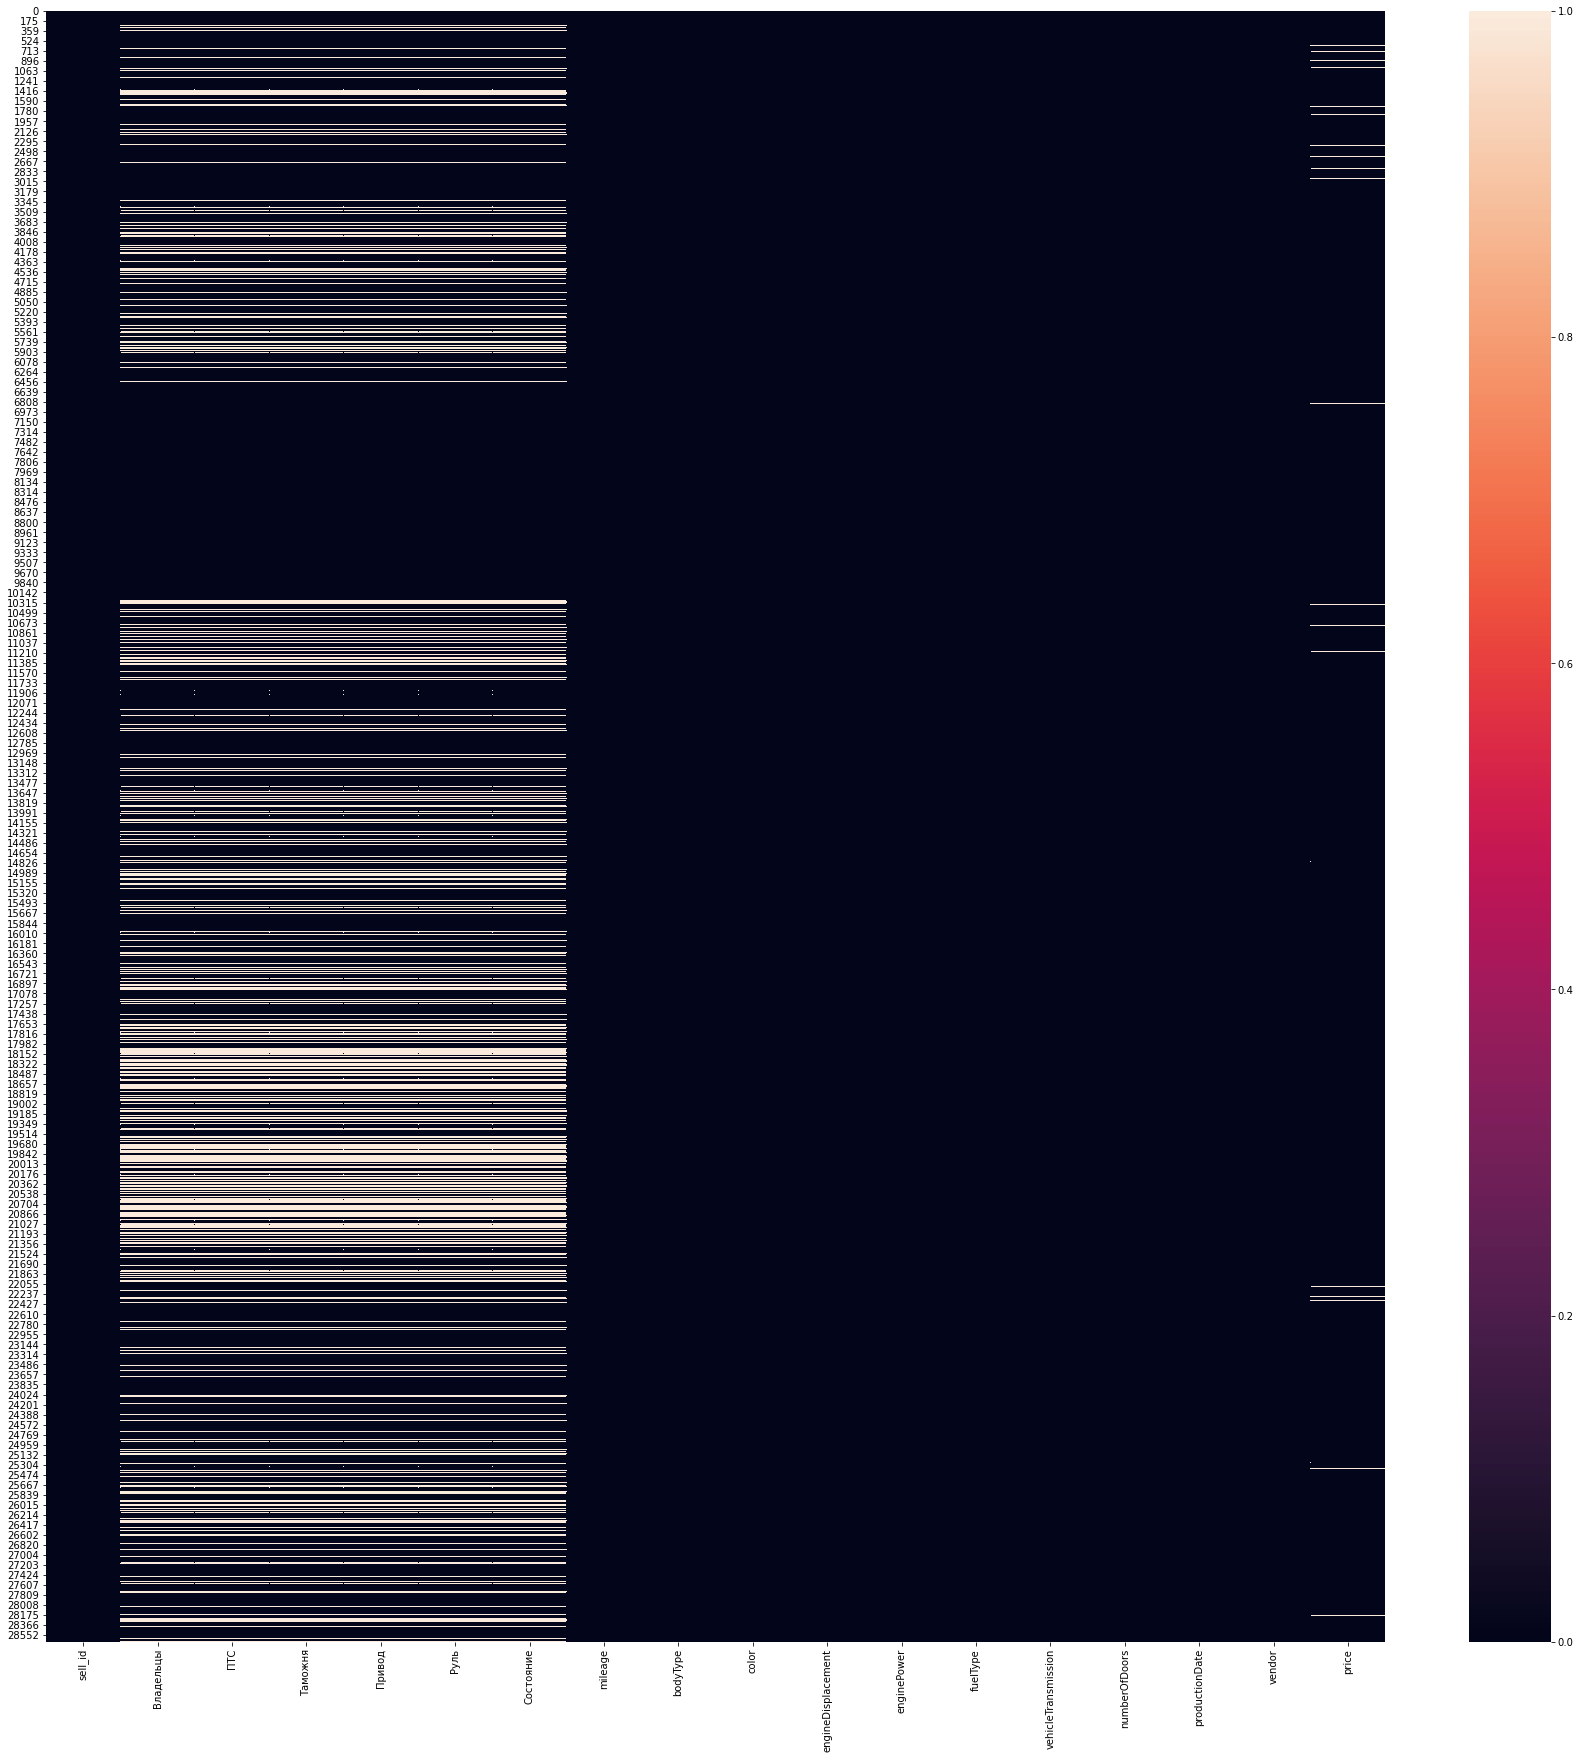

In [541]:
#Построим график пропусков
plt.subplots(figsize=(30, 30))
sns.heatmap(df.isnull())

In [542]:
#удаляем пропуски где нет цены
df.dropna(subset=['price'],inplace = True)

In [543]:
df['Владельцы'].value_counts()

1 владелец     7670
3 или более    7233
2 владельца    4576
Name: Владельцы, dtype: int64

In [544]:
#предположим что пропуски относятся к новым автомобилям, поэтому заполним их "0"
df['Владельцы']=df['Владельцы'].fillna(0)

In [545]:
df['Владельцы'] = df['Владельцы'].apply(lambda x: 1 if str(x).startswith('1') else 2 if str(x).startswith('2') else 3 if str(x).startswith('3') else x)

In [546]:
df['ПТС'].value_counts()

Оригинал    17180
Дубликат     2299
Name: ПТС, dtype: int64

In [547]:
df['ПТС'] = df['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0)

In [548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25375 entries, 0 to 28672
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sell_id              25375 non-null  object 
 1   Владельцы            25375 non-null  int64  
 2   ПТС                  25375 non-null  int64  
 3   Таможня              19479 non-null  object 
 4   Привод               19479 non-null  object 
 5   Руль                 19479 non-null  object 
 6   Состояние            19479 non-null  object 
 7   mileage              25375 non-null  int64  
 8   bodyType             25375 non-null  object 
 9   color                25375 non-null  object 
 10  engineDisplacement   25375 non-null  object 
 11  enginePower          25375 non-null  object 
 12  fuelType             25375 non-null  object 
 13  vehicleTransmission  25375 non-null  object 
 14  numberOfDoors        25375 non-null  int64  
 15  productionDate       25375 non-null 

In [549]:
df['Привод'].value_counts()# get_dammies

передний    11207
полный       7131
задний       1141
Name: Привод, dtype: int64

In [550]:
# применяем get_dummies и удаляем признак "Привод"
df=pd.concat([df, pd.get_dummies(df['Привод'])], axis=1)
df.drop(columns=['Привод'], inplace= True)

In [551]:
df['Руль'].value_counts()

Левый     19122
Правый      357
Name: Руль, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


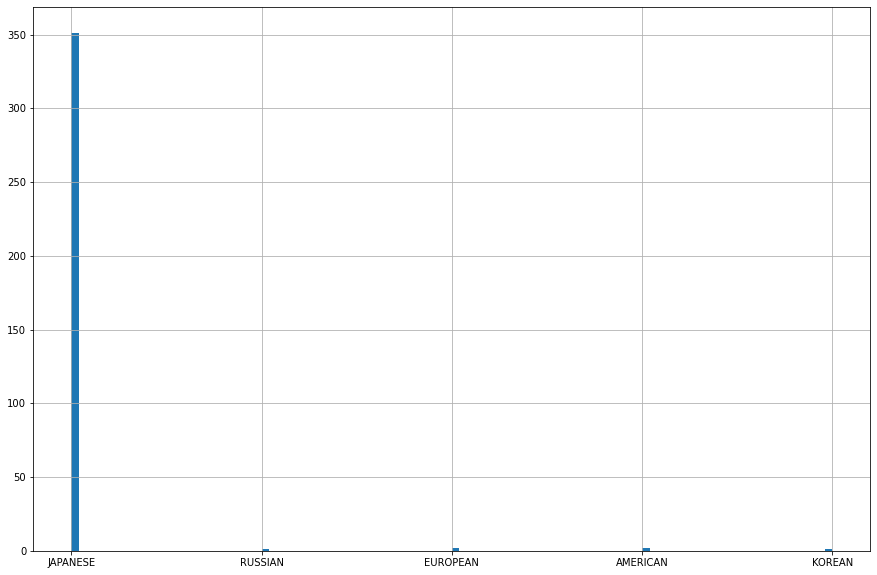

In [552]:
#Проверим корееляцию стороный руля и страны происхождения. очевидно правосторонний руль у автомобилей произвденных в Японии. 
print(df['vendor'][df['Руль'] == 'Правый'].hist(bins=100))

In [553]:
#Заполним nans исходя из предыдущего вывода.
def fill_steering(row):
    if pd.isnull(row['Руль']) and row['vendor'] == 'JAPANESE':
        return 1
    if pd.isnull(row['Руль']) and row['vendor'] != 'JAPANESE':
        return 0
    if row['Руль'] == 'Левый':
        return 0
    if row['Руль'] == 'Правый':
        return 1

In [554]:
df['Руль']=df.apply(fill_steering,axis=1)# применяем функцию

In [555]:
df['Состояние'].value_counts()

Не требует ремонта    19479
Name: Состояние, dtype: int64

In [556]:
# предположим что пропуски относятся к новым автомобилям, делаем вывод что все автомобили не требуют ремонта
# поэтому удаляем признак
df.drop(columns=['Состояние'], inplace= True)

In [557]:
df['Таможня'].value_counts()

Растаможен    19479
Name: Таможня, dtype: int64

In [558]:
# предположим что пропуски относятся к автомобилям,который растаможен делаем вывод что все автомобили растаможены
# поэтому удаляем признак
df.drop(columns=['Таможня'], inplace= True)

In [559]:
df['bodyType'].value_counts()

внедорожник 5 дв.          9939
седан                      8663
хэтчбек 5 дв.              2791
универсал 5 дв.            1430
лифтбек                     619
минивэн                     501
купе                        396
компактвэн                  263
хэтчбек 3 дв.               256
внедорожник 3 дв.           193
пикап двойная кабина        135
фургон                       70
купе-хардтоп                 47
кабриолет                    33
родстер                      16
пикап полуторная кабина       6
микровэн                      4
пикап одинарная кабина        4
седан-хардтоп                 3
хэтчбек 4 дв.                 2
внедорожник открытый          2
лимузин                       2
Name: bodyType, dtype: int64

In [560]:
df=pd.concat([df, pd.get_dummies(df['bodyType'])], axis=1) # применяем get_dummies
df.drop(columns=['bodyType'], inplace= True)

In [561]:
df['Владельцы'].value_counts()

1    7670
3    7233
0    5896
2    4576
Name: Владельцы, dtype: int64

In [562]:
df=pd.concat([df, pd.get_dummies(df['color'])], axis=1)
df.drop(columns=['color'], inplace= True)

In [563]:
df['engineDisplacement'].value_counts()

1.6 LTR    8584
2.0 LTR    5532
3.0 LTR    1584
2.5 LTR    1228
1.8 LTR    1142
1.4 LTR    1058
1.5 LTR     971
3.5 LTR     711
1.3 LTR     683
4.0 LTR     468
2.4 LTR     324
2.8 LTR     313
2.9 LTR     296
2.2 LTR     273
1.7 LTR     257
2.1 LTR     249
2.3 LTR     244
4.5 LTR     197
2.7 LTR     191
5.5 LTR     164
4.7 LTR     150
 LTR         79
4.2 LTR      76
1.2 LTR      76
4.6 LTR      57
3.2 LTR      45
1.0 LTR      38
3.1 LTR      37
5.0 LTR      37
3.6 LTR      28
2.6 LTR      23
1.9 LTR      23
3.7 LTR      23
5.4 LTR      22
5.7 LTR      21
0.8 LTR      18
3.4 LTR      16
6.2 LTR      15
6.0 LTR      14
3.8 LTR      13
3.3 LTR      12
5.2 LTR      11
4.1 LTR       9
5.9 LTR       9
1.1 LTR       9
4.4 LTR       8
5.3 LTR       7
5.6 LTR       6
5.8 LTR       5
4.3 LTR       4
4.9 LTR       3
6.8 LTR       3
6.1 LTR       3
6.3 LTR       3
0.7 LTR       3
Name: engineDisplacement, dtype: int64

In [564]:
# Преобразуем признак в численный и сразу же удаляем пропуски
df['engineDisplacement']=df['engineDisplacement'].apply(lambda x: float(str(x).replace('LTR', '')) if str(x).replace('LTR', '').strip() != '' else None)

In [565]:
df.dropna(subset=['engineDisplacement'],inplace = True)

In [566]:
df.loc[:, 'Владельцы':'price'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25296 entries, 0 to 28672
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Владельцы            25296 non-null  int64  
 1   ПТС                  25296 non-null  int64  
 2   Руль                 25296 non-null  int64  
 3   mileage              25296 non-null  int64  
 4   engineDisplacement   25296 non-null  float64
 5   enginePower          25296 non-null  object 
 6   fuelType             25296 non-null  object 
 7   vehicleTransmission  25296 non-null  object 
 8   numberOfDoors        25296 non-null  int64  
 9   productionDate       25296 non-null  int64  
 10  vendor               25293 non-null  object 
 11  price                25296 non-null  float64
dtypes: float64(2), int64(6), object(4)
memory usage: 2.5+ MB


<AxesSubplot:>

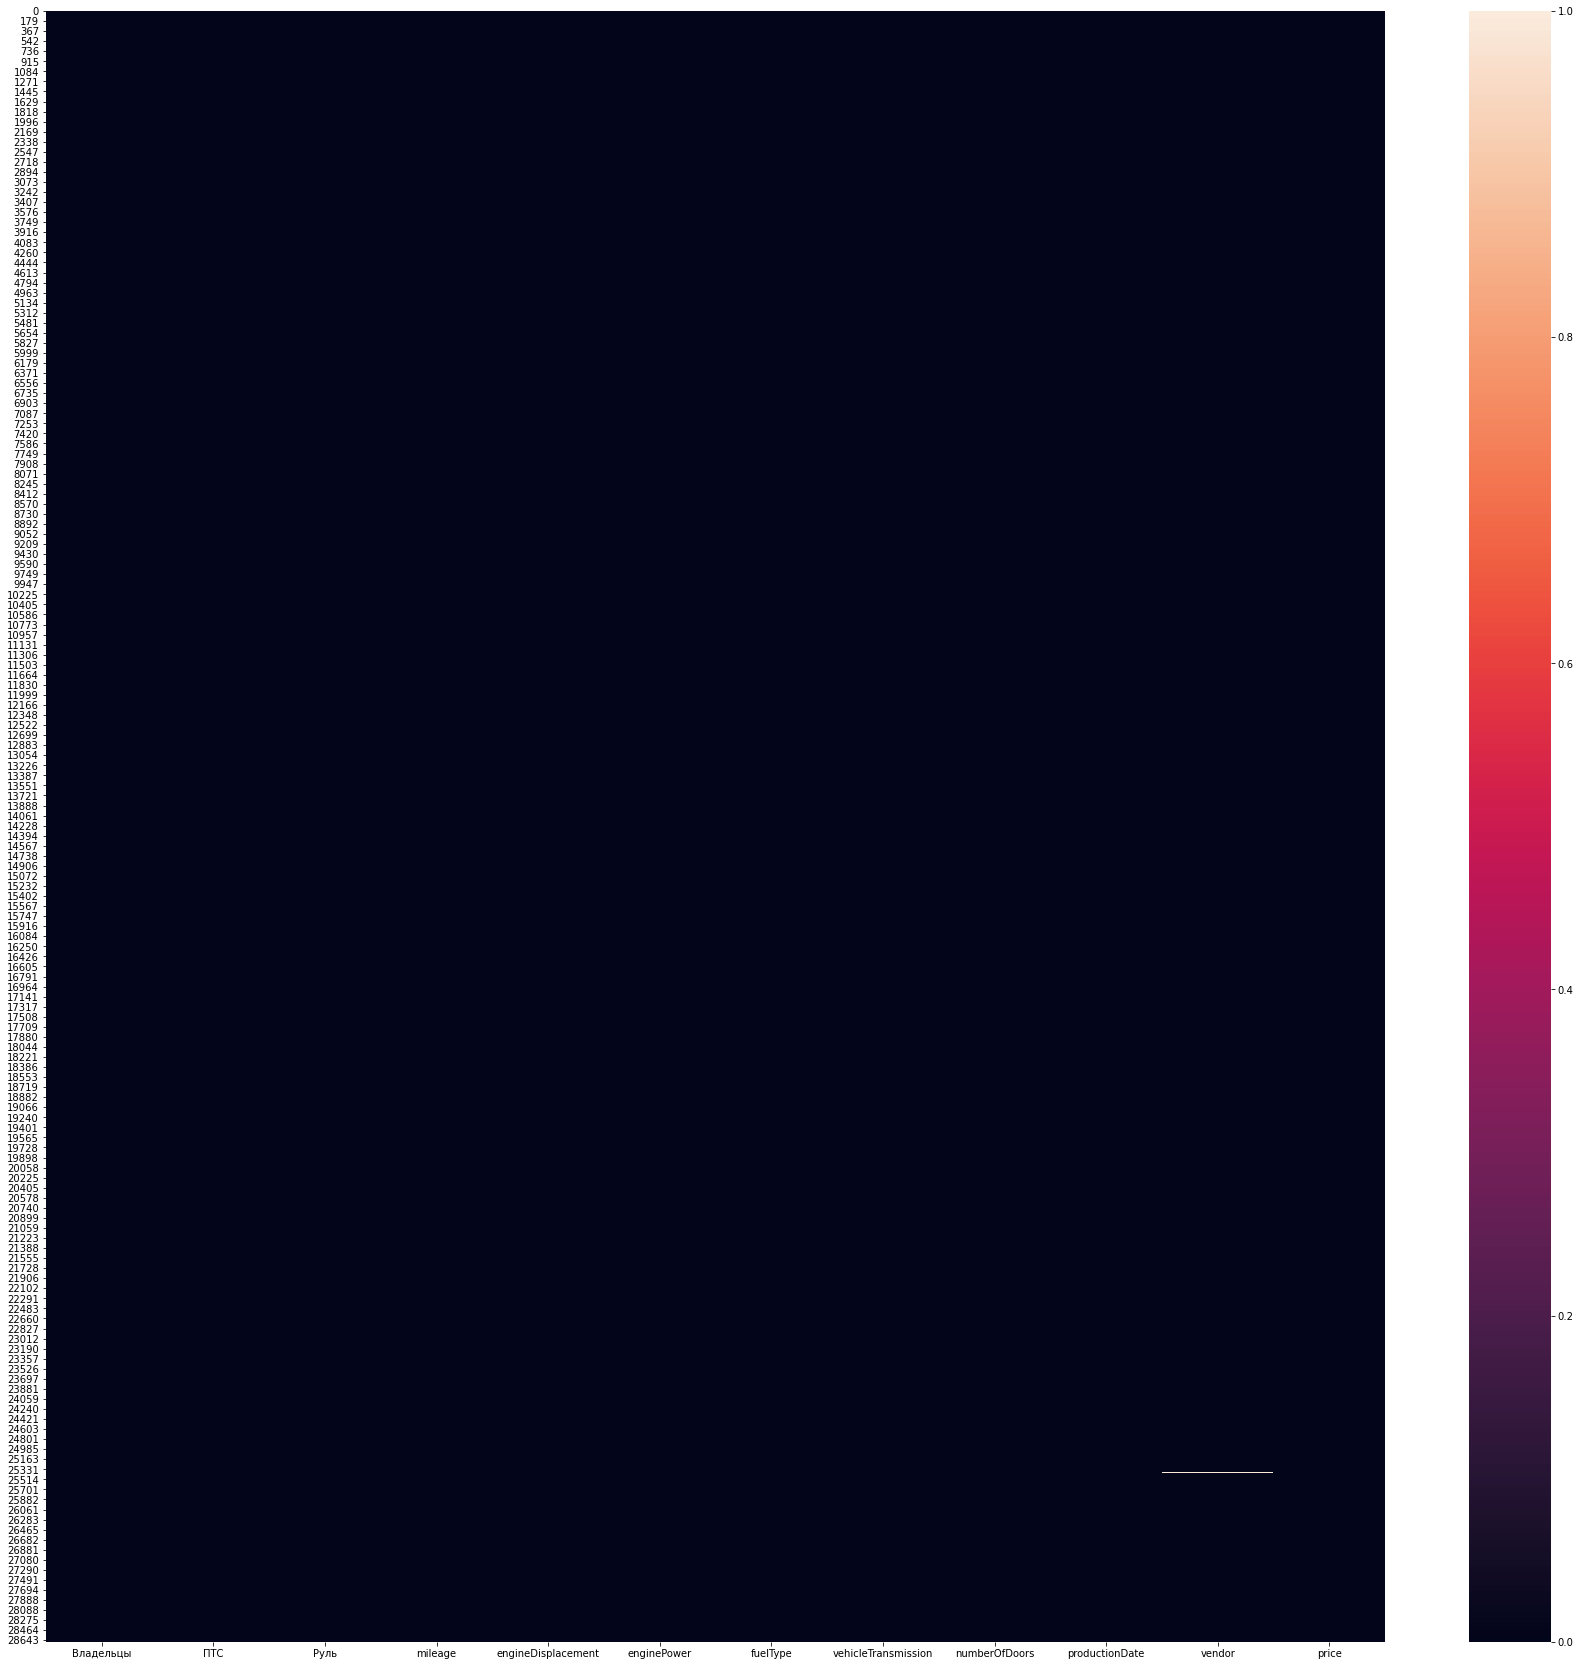

In [567]:
#Построим график пропусков
plt.subplots(figsize=(30, 30))
sns.heatmap(df.loc[:, 'Владельцы':'price'].isnull())

In [568]:
#удалим пропуски "vendor"
df.dropna(subset=['vendor'],inplace = True)

In [569]:
df['enginePower'] = df['enginePower'].apply(lambda x: x.split()[0])

In [570]:
df['enginePower']

0        197
1        180
2        115
3        149
4         70
        ... 
28668    122
28669     98
28670    106
28671     87
28672    113
Name: enginePower, Length: 25293, dtype: object

In [571]:
df['fuelType'].value_counts()

бензин    21711
дизель     3485
гибрид       88
газ           9
Name: fuelType, dtype: int64

In [572]:
df=pd.concat([df, pd.get_dummies(df['fuelType'])], axis=1)# применяем get_dummies
df.drop(columns=['fuelType'], inplace= True)

In [573]:
df['numberOfDoors'].value_counts()#оставляем без изменений

5    15406
4     8922
2      503
3      462
Name: numberOfDoors, dtype: int64

In [574]:
df['productionDate'].value_counts()

2021    6696
2018    1674
2017    1513
2019    1345
2013    1319
2012    1315
2016    1268
2014    1231
2015    1131
2011    1104
2020    1091
2008    1048
2007     800
2010     783
2006     535
2009     398
2005     343
2004     263
2003     199
2001     180
2002     173
2000     131
1997      95
1998      92
1999      92
1993      55
1994      53
1996      51
1995      50
1991      49
1992      45
1987      28
1989      27
1988      27
1990      26
1986      10
1984       8
1985       7
1982       6
1983       6
1974       5
1980       3
1966       3
1978       2
1976       2
1981       2
1975       2
1959       2
1967       2
1977       1
1973       1
1960       1
Name: productionDate, dtype: int64

In [575]:
df['vehicleTransmission'].value_counts()

автоматическая      11634
механическая         8597
роботизированная     3142
вариатор             1920
Name: vehicleTransmission, dtype: int64

In [576]:
df=pd.concat([df, pd.get_dummies(df['vehicleTransmission'])], axis=1)
df.drop(columns=['vehicleTransmission'], inplace= True)

In [577]:
df['vendor'].value_counts()

EUROPEAN    10945
KOREAN       3985
JAPANESE     3660
AMERICAN     3409
RUSSIAN      3245
CHINESE        49
Name: vendor, dtype: int64

In [578]:
df=pd.concat([df, pd.get_dummies(df['vendor'])], axis=1)
df.drop(columns=['vendor'], inplace= True)

<AxesSubplot:>

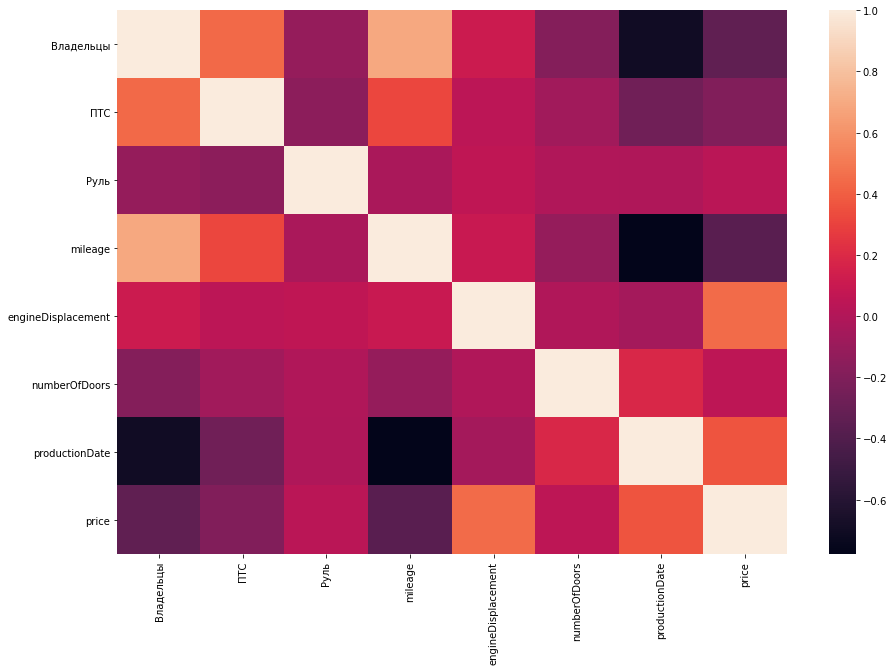

In [579]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.loc[:, 'Владельцы':'price'].corr())

In [580]:
df

,sell_id,Владельцы,ПТС,Руль,mileage,engineDisplacement,enginePower,numberOfDoors,productionDate,price,...,автоматическая,вариатор,механическая,роботизированная,AMERICAN,CHINESE,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1105117076-5afcca8a,0,0,0,0,2.0,197,2,2020,5360064.0,...,1,0,0,0,0,0,1,0,0,0
1,1105828980-edee6d5a,1,1,0,62000,2.5,180,5,2018,2295000.0,...,1,0,0,0,0,0,0,1,0,0
2,1105892143-a25eb3c3,3,0,0,185566,1.6,115,4,2006,320000.0,...,0,0,1,0,0,0,1,0,0,0
3,1105979835-fca730a5,0,0,0,0,2.0,149,5,2021,1520000.0,...,1,0,0,0,0,0,0,0,1,0
4,1106014848-0b67bbc0,3,0,1,300000,1.0,70,5,2000,175000.0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28668,1106084272-590d68c9,2,1,0,152000,1.8,122,5,2016,554990.0,...,0,0,0,1,0,0,0,0,0,1
28669,1106067416-811209a6,3,1,0,165040,1.6,98,5,2010,309000.0,...,0,0,1,0,0,0,0,0,0,1
28670,1106085089-af6ac618,1,1,0,128135,1.6,106,4,2016,624000.0,...,0,0,0,1,0,0,0,0,0,1
28671,1106082394-0ee6a8ef,1,1,0,11801,1.6,87,4,2020,698000.0,...,0,0,1,0,0,0,0,0,0,1


In [581]:
df.drop(columns=['mileage','Владельцы'], inplace= True)# удаляем mileage и валдельцы,т.к. коррелируют с ProductionDate

In [582]:
df['Руль'].value_counts()

0    24406
1      887
Name: Руль, dtype: int64

In [583]:
# нормализуем данные 'engineDisplacement', 'enginePower', 'productionDate'
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale=['engineDisplacement', 'enginePower', 'productionDate']
scaler.fit(df[columns_to_scale])
df[columns_to_scale]=scaler.transform(df[columns_to_scale])

In [584]:
df

,sell_id,ПТС,Руль,engineDisplacement,enginePower,numberOfDoors,productionDate,price,задний,передний,...,автоматическая,вариатор,механическая,роботизированная,AMERICAN,CHINESE,EUROPEAN,JAPANESE,KOREAN,RUSSIAN
0,1105117076-5afcca8a,0,0,0.213115,0.239766,2,0.983871,5360064.0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,1105828980-edee6d5a,1,0,0.295082,0.214912,5,0.951613,2295000.0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1105892143-a25eb3c3,0,0,0.147541,0.119883,4,0.758065,320000.0,0,1,...,0,0,1,0,0,0,1,0,0,0
3,1105979835-fca730a5,0,0,0.213115,0.169591,5,1.000000,1520000.0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1106014848-0b67bbc0,0,1,0.049180,0.054094,5,0.661290,175000.0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28668,1106084272-590d68c9,1,0,0.180328,0.130117,5,0.919355,554990.0,0,1,...,0,0,0,1,0,0,0,0,0,1
28669,1106067416-811209a6,1,0,0.147541,0.095029,5,0.822581,309000.0,0,1,...,0,0,1,0,0,0,0,0,0,1
28670,1106085089-af6ac618,1,0,0.147541,0.106725,4,0.919355,624000.0,0,1,...,0,0,0,1,0,0,0,0,0,1
28671,1106082394-0ee6a8ef,1,0,0.147541,0.078947,4,0.983871,698000.0,0,1,...,0,0,1,0,0,0,0,0,0,1


<AxesSubplot:>

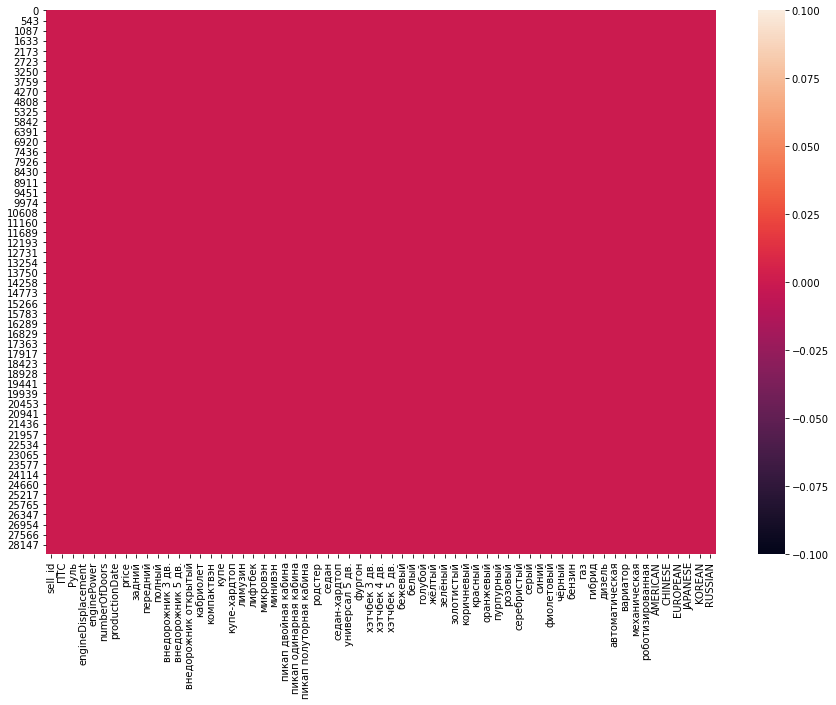

In [585]:
sns.heatmap(df.isnull())

In [586]:
RANDOM_SEED = 42 # зафиксируем random_seed